目的：datファイルやXMLファイルの構造をexploreする

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%cd /users/keimy/git/oct2age
%pwd

/Users/keimy/git/OCT2Age


'/Users/keimy/git/OCT2Age'

# check date of kenshin data

In [ ]:
import pandas as pd

df2016 = pd.read_csv("data_kenshin/2016R2.csv", skiprows=0)
df2017 = pd.read_csv("data_kenshin/2017R2.csv", skiprows=0)
df2018 = pd.read_csv("data_kenshin/2018R2.csv", skiprows=0)
df_msp = pd.read_csv("/Users/keimy/git/oct2age/data_kenshin/msp.csv", skiprows=0)


# df2018から99999999を除外
df2018 = df2018[df2018.kenshindate != 99999999]
df2016.kenshindate.min(), df2018.kenshindate.max(), df_msp.date.min(), df_msp.date.max()


# check XML

In [7]:
import xml.etree.ElementTree as ET

# XMLファイルの読み込み
file_path = "data_xml/00120141010_20141010_R_71_OCTAnalysisInfo.xml"
tree = ET.parse(file_path)
root = tree.getroot()

# すべてのユニークなタグを探索
unique_tags = set()
for elem in root.iter():
    unique_tags.add(elem.tag)

# タグごとにdataを抽出してprint
for tag in unique_tags:
    data = []
    for elem in root.findall(f'.//{tag}'):
        data.append(elem.text)
    # print(tag, data)

QSを抽出

In [9]:
import xml.etree.ElementTree as ET

def extract_QS_from_XML(prefix_per_patient):
    file_path = prefix_per_patient + "_OCTAnalysisInfo.xml"
    tree = ET.parse(file_path)
    root = tree.getroot()

    tag = "RetinalImageQuality"
    data_for_QS = []

    for elem in root.findall(f'.//{tag}'):
        data_for_QS.append(elem.text)

    QS = float(data_for_QS[0])
    return QS

# 使用例
prefix_per_patient = "data_xml/00120141010_20141010_L_72"
extract_QS_from_XML(prefix_per_patient)


35.0285491943359

# check DAT

In [ ]:
import struct

def read_boundary(file_path):
    # ファイルをバイナリモードで開く
    with open(file_path, 'rb') as file:
        data = file.read()

    # バイナリデータを16ビット整数のリストに変換
    # '<' はリトルエンディアン、'H' はunsigned short (16ビット整数) 
    data_int = struct.unpack('<' + 'H' * (len(data) // 2), data)
    data_int = np.array(data_int).reshape(128, 512).T

    return data_int

def extract_layers_from_DAT(prefix_per_patient):
    BDY_ILM = read_boundary(prefix_per_patient+'_ILM.dat')
    # RNFL
    BDY_RNFLGCL = read_boundary(prefix_per_patient+'_RNFLGCL.dat')
    # GCL
    BDY_IPLINL = read_boundary(prefix_per_patient+'_IPLINL.dat')
    # OUTER
    # BDY_ISOS = read_boundary(prefix_per_patient+'_ISOS.dat')
    # BDY_OSRPE = read_boundary(prefix_per_patient+'_OSRPE.dat')
    BDY_BM = read_boundary(prefix_per_patient+'_BM.dat')

    # 差分
    RNFL = BDY_ILM - BDY_RNFLGCL
    GCL = BDY_RNFLGCL - BDY_IPLINL
    OUTER = BDY_IPLINL - BDY_BM

    # 右目の向きに統一。なぜか右目の場合のみ反転が必要
    if "_R_" in prefix_per_patient:
        RNFL = RNFL[:,::-1]
        GCL = GCL[:,::-1]
        OUTER = OUTER[:,::-1]

    return RNFL, GCL, OUTER


prefix_per_patient = "data_dat/00120141010_20141010_R_71_BOUNDARY"
RNFL, GCL, OUTER = extract_layers_from_DAT(prefix_per_patient)


RNFL.min(), RNFL.max(), GCL.min(), GCL.max(), OUTER.min(), OUTER.max()

In [ ]:
def draw_heatmap_with_scale(arr, vmin, vmax):
    arr = arr[:,:80]
    """
    Draws a heatmap from a 2D array 'arr', considering its min and max values.
    Larger values are shown in green, and smaller values in red.
    """
    plt.figure(figsize=(6, 5))
    plt.imshow(arr, cmap='RdYlGn', aspect='auto', interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

# Drawing the heatmap
draw_heatmap_with_scale(RNFL, 0, 100)
draw_heatmap_with_scale(GCL, 0, 50)
draw_heatmap_with_scale(OUTER, 40, 100)


# extract data and save as HDF5

In [2]:
import glob

dat_files = glob.glob("/Volumes/DATA_HDPD-S/dat/*")
xml_files = glob.glob("/Volumes/DATA_HDPD-S/xml/*")

xml_prefixes = ["_".join(xml_file.split("_")[:-1]) for xml_file in xml_files]
dat_prefixes = ["_".join(dat_file.split("_")[:-1]) for dat_file in dat_files]

xml_prefixes = list(set(xml_prefixes))
dat_prefixes = list(set(dat_prefixes))

len(dat_files), len(xml_files), len(dat_prefixes), len(xml_prefixes)

(52356, 26178, 8726, 8726)

In [3]:
dat_prefixes[:5], xml_prefixes[:5]

(['/Volumes/DATA_HDPD-S/dat/01020160729_20160729_L_53655_BOUNDARY',
  '/Volumes/DATA_HDPD-S/dat/01220170410_20170410_L_76913_BOUNDARY',
  '/Volumes/DATA_HDPD-S/dat/00520171023_20171023_L_97250_BOUNDARY',
  '/Volumes/DATA_HDPD-S/dat/00820160725_20160725_L_53050_BOUNDARY',
  '/Volumes/DATA_HDPD-S/dat/00620170323_20170323_R_75341_BOUNDARY'],
 ['/Volumes/DATA_HDPD-S/xml/00620170530_20170530_L_82261',
  '/Volumes/DATA_HDPD-S/xml/00420170725_20170725_L_88785',
  '/Volumes/DATA_HDPD-S/xml/01020161202_20161202_L_66043',
  '/Volumes/DATA_HDPD-S/xml/01220160830_20160830_R_55922',
  '/Volumes/DATA_HDPD-S/xml/00520161208_20161208_R_66691'])

666/8726例が該当

In [14]:
from src.extract_data import extract_QS_from_XML, extract_layers_from_DAT
from tqdm import tqdm
import h5py

# HDF5ファイルに保存
path = "data_hdf5/OCT.h5"

with h5py.File(path, 'w') as f:
    for prefix_per_patient in tqdm(xml_prefixes):
        QS = extract_QS_from_XML(prefix_per_patient)
        if QS < 40: continue

        # QS 40以上ならば、datファイルを読み込む
        prefix_per_patient = prefix_per_patient.replace("xml", "dat")
        RNFL, GCL, OUTER = extract_layers_from_DAT(prefix_per_patient)

        # HDF5ファイルのためのグループ作成
        prefix_per_patient = prefix_per_patient.split("/")[-1]
        grp = f.create_group(prefix_per_patient)
        # データセットをグループ内に保存
        grp.create_dataset('RNFL', data=RNFL)
        grp.create_dataset('GCL', data=GCL)
        grp.create_dataset('OUTER', data=OUTER)


100%|██████████| 8726/8726 [00:33<00:00, 260.41it/s]


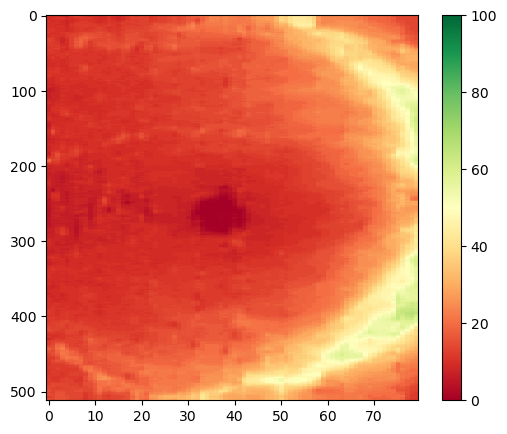

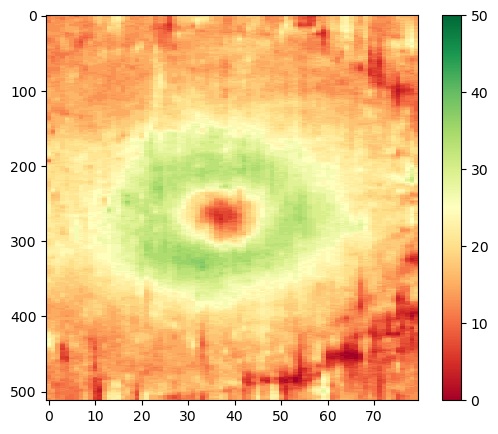

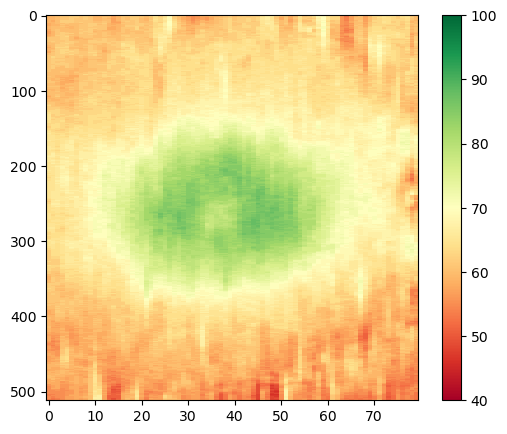

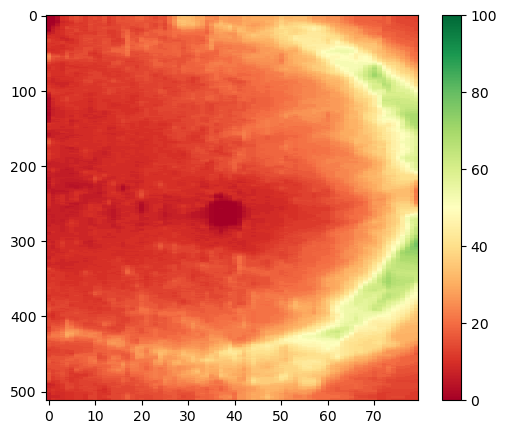

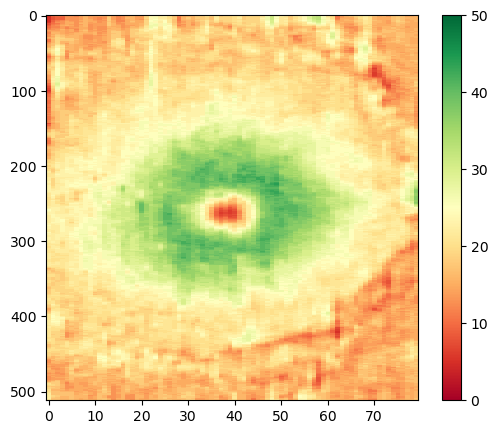

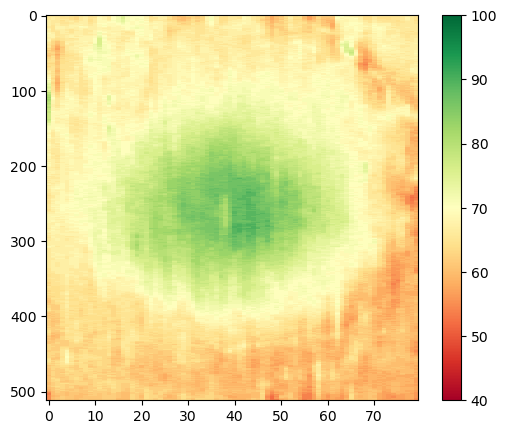

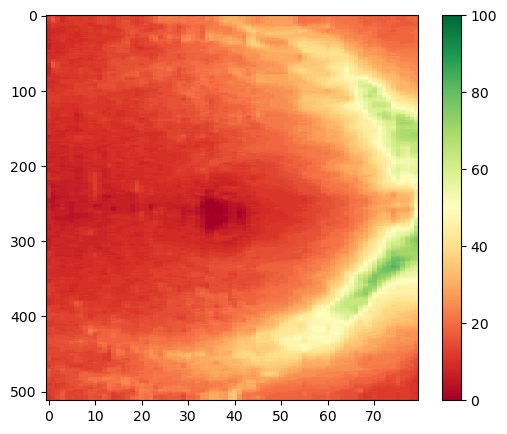

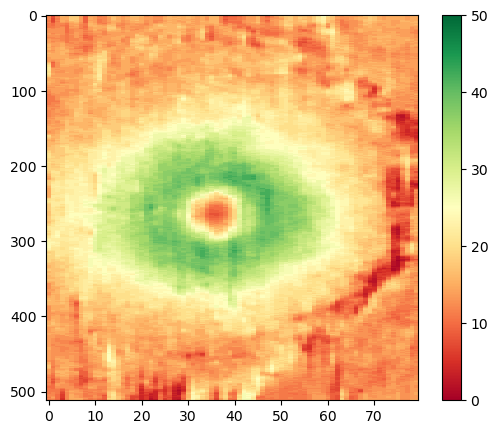

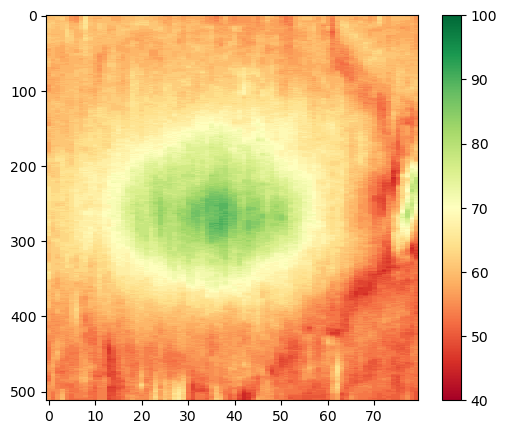

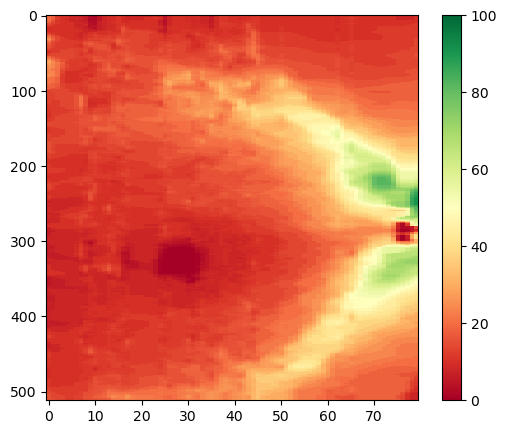

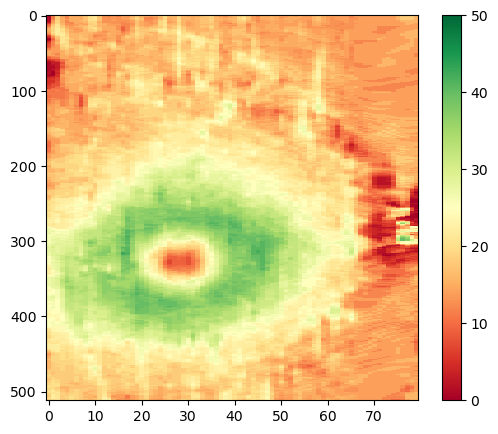

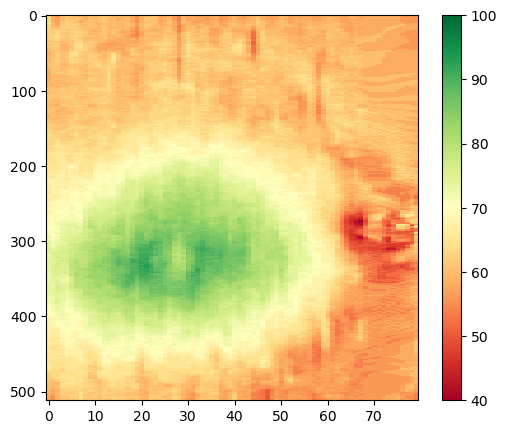

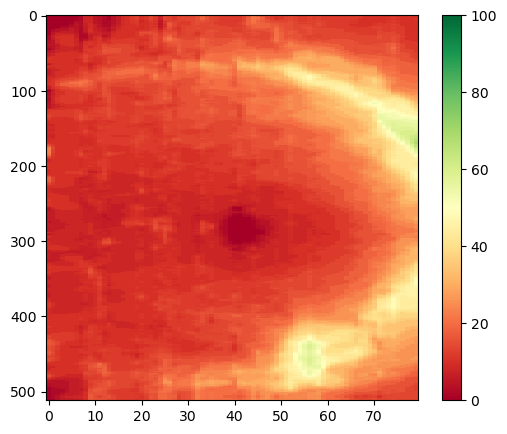

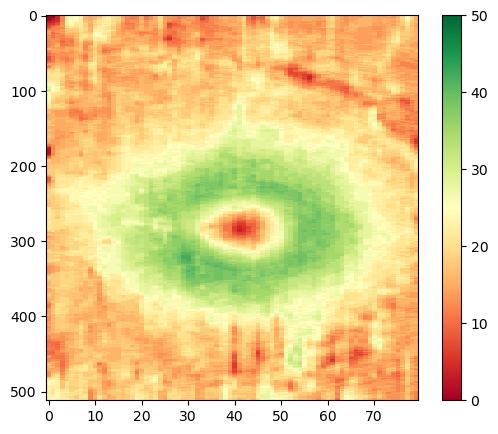

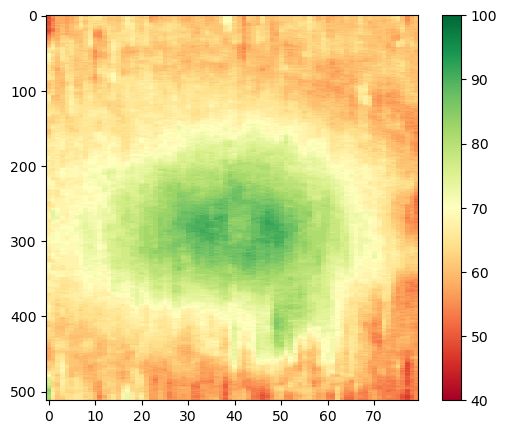

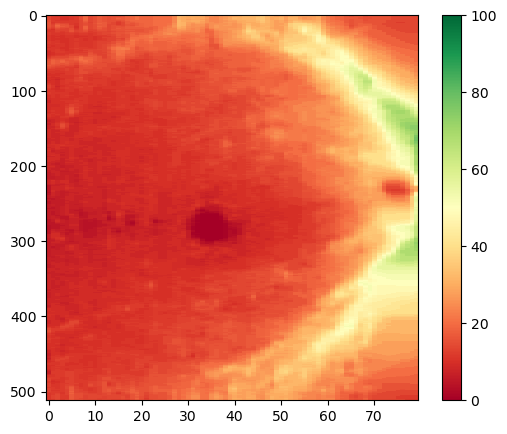

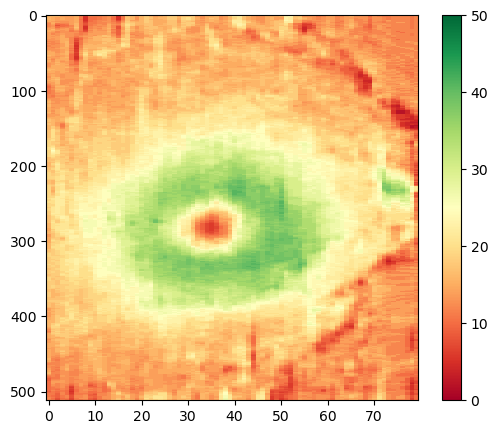

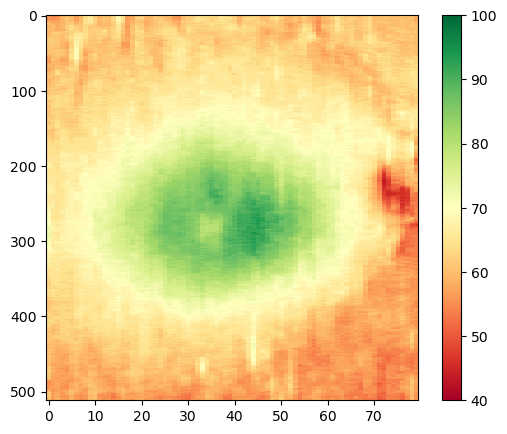

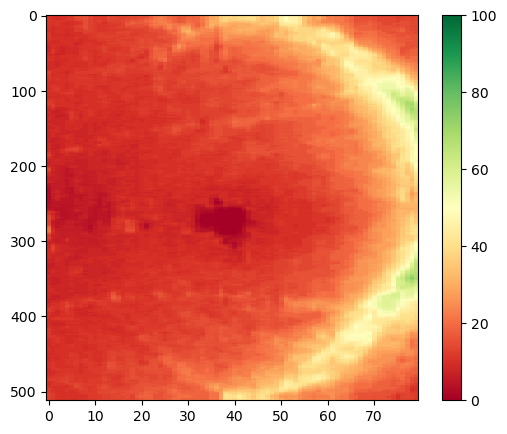

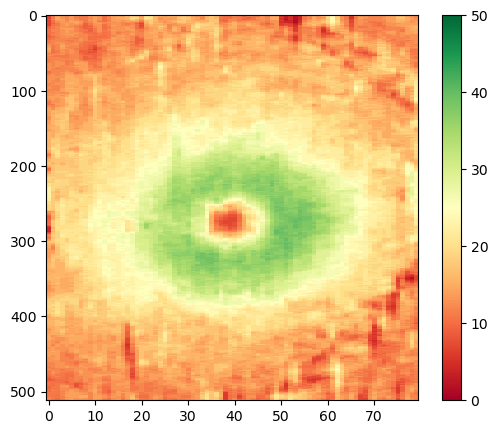

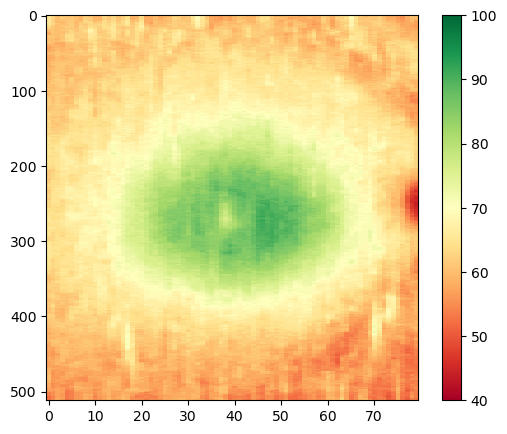

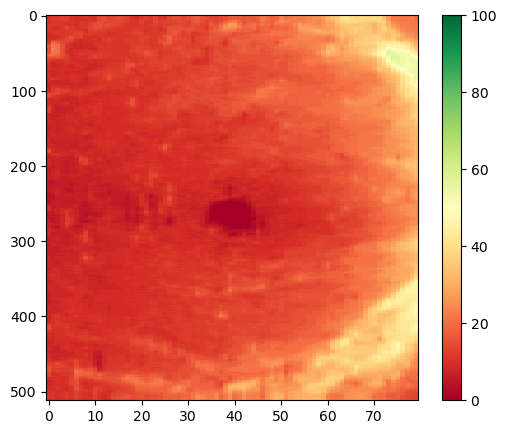

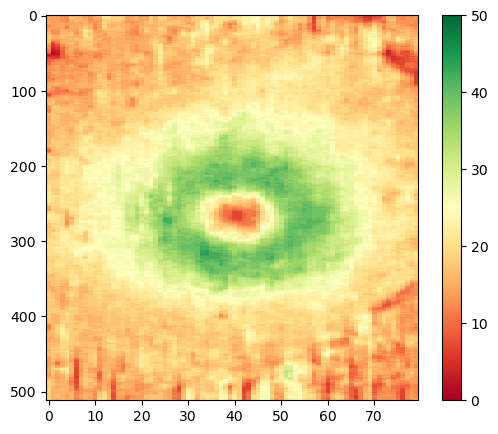

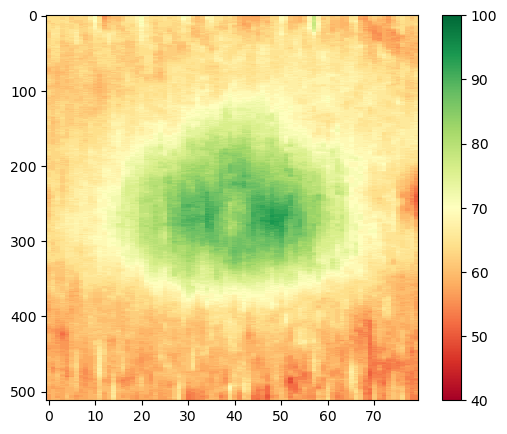

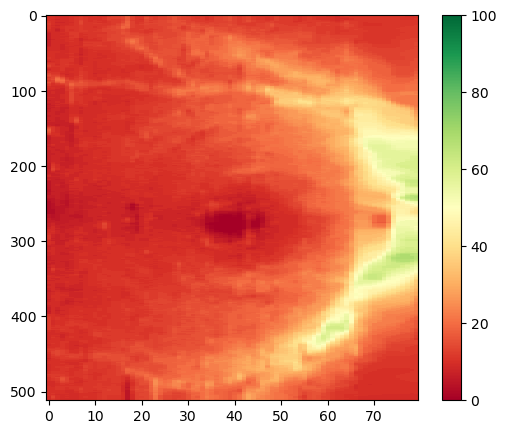

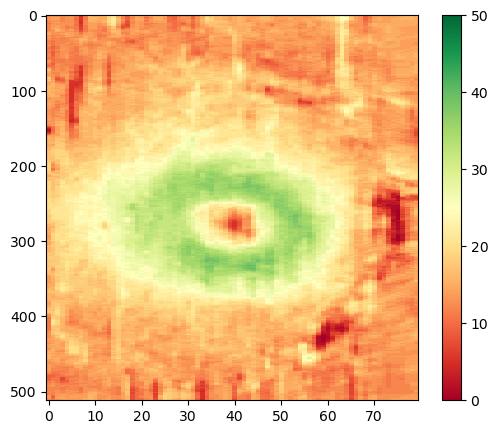

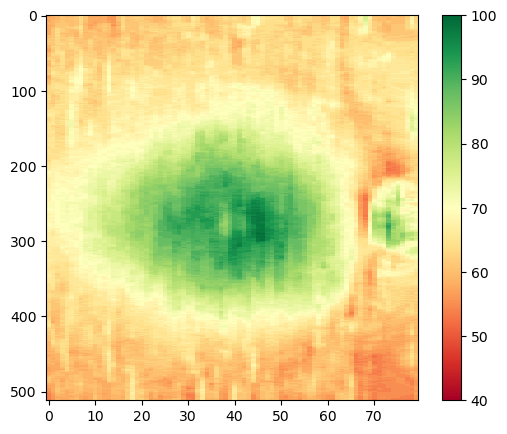

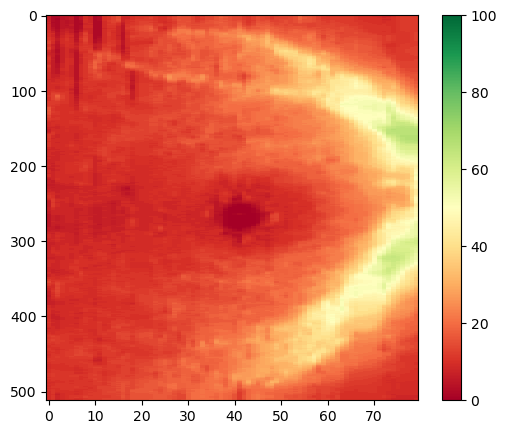

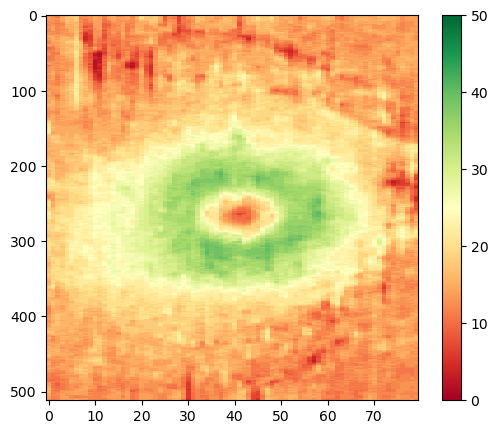

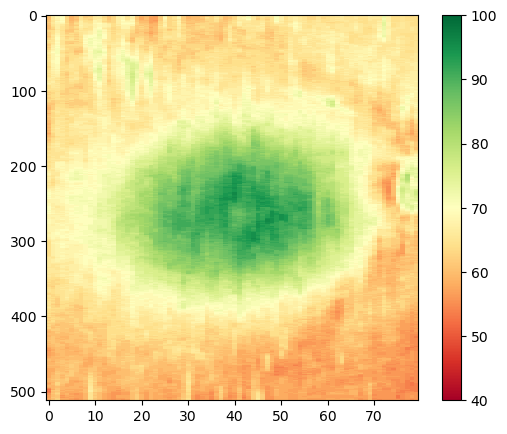

In [26]:
from tqdm import tqdm
import h5py

def draw_heatmap_with_scale(arr, vmin, vmax):
    arr = arr[:,:80]
    """
    Draws a heatmap from a 2D array 'arr', considering its min and max values.
    Larger values are shown in green, and smaller values in red.
    """
    plt.figure(figsize=(6, 5))
    plt.imshow(arr, cmap='RdYlGn', aspect='auto', interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

path = "data_hdf5/OCT.h5"
with h5py.File(path, 'r') as file:
    keys = list(file.keys())

with h5py.File(path, 'r') as file:
    for key in keys[:10]:
        RNFL = file[key]['RNFL'][:]
        GCL = file[key]['GCL'][:]
        OUTER = file[key]['OUTER'][:]

        draw_heatmap_with_scale(RNFL, 0, 100)
        draw_heatmap_with_scale(GCL, 0, 50)
        draw_heatmap_with_scale(OUTER, 40, 100)
